In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Application to bone marrow data

Now we try this strategy on real data. In particular, we are using one of the batches of bone marrow data from the recently published Mouse Cell Atlas. This batch has 5,189 cells and expression values for 16,827 genes. For the sake of speeding up the analysis this post we randomly sample 3,000 of the cells.

In [ ]:
counts = pd.read_csv('MCA data/BoneMarrow3_dge.txt.gz', sep=' ')

In [3]:
logex = np.log1p(counts)

In [4]:
logex.shape

(16827, 5189)

In [5]:
# Subsample cells for a little extra speed
s = logex.T.sample(3000)

In [6]:
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(25)

In [7]:
Y = pca.fit_transform(s)

In [8]:
c = np.expm1(s).sum(1)

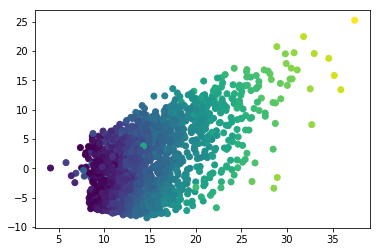

In [9]:
plt.scatter(Y[:, 0], Y[:, 1], c=np.log(c))

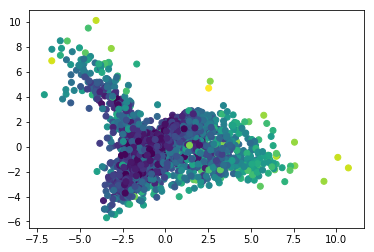

In [10]:
plt.scatter(Y[:, 2], Y[:, 3], c=np.log(c))

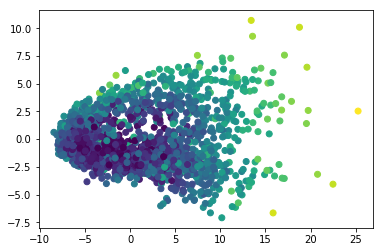

In [11]:
plt.scatter(Y[:, 1], Y[:, 2], c=np.log(c))

In [12]:
from sklearn.manifold import TSNE

In [13]:
tsne = TSNE()

In [14]:
YY = tsne.fit_transform(Y[:, 2:11])

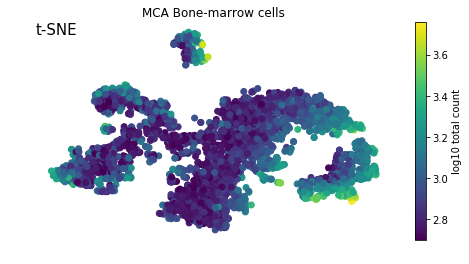

In [15]:
figsize(8, 4)
plt.scatter(YY[:, 0], YY[:, 1], c=np.log10(c))
plt.axis('off');
plt.annotate('t-SNE', (0, 1), ha='left', va='top', size=15, xycoords='axes fraction');
plt.colorbar(label='log10 total count');
plt.title('MCA Bone-marrow cells');

In [16]:
from sklearn.mixture import BayesianGaussianMixture

Now we perform the same procedure of training GMM's and attempting to predict held out data with logistic regression.

In [27]:
def get_clusters(K):
    gmm = BayesianGaussianMixture(n_components=K, max_iter=1000)
    gmm.fit(Y[:, 2:20])
    cs = gmm.predict(Y[:, 2:20])
    
    return cs

In [28]:
def plot_clusters(cs):
    plt.scatter(YY[:, 0], YY[:, 1], c=cs, cmap=cm.YlOrRd, vmin=-cs.max() / 3)
    plt.annotate('t-SNE', (0, 1), ha='left', va='top', size=15, xycoords='axes fraction');
    plt.axis('off');

In [19]:
from NaiveDE import cell_types

In [49]:
def make_iteration(K, C):
    c = get_clusters(K)
    test_prob, test_truth, lr_res, lr = cell_types.logistic_model(s, c, sparsity=C)
    
    plt.subplot(2, 1, 1)
    plot_clusters(c)
    plt.title(f'K = {K}')

    plt.subplot(2, 1, 2)
    cell_types.plot_roc(test_prob, test_truth, lr)
    
    return c, lr_res, lr

[ 8  3 18 15 26  8 34  8  5  6 19 23  5 16 21  7 10 10  4  5]


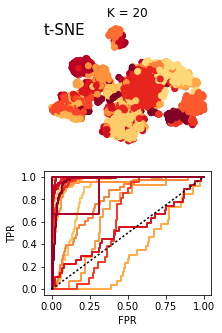

In [36]:
figsize(3, 5)
make_iteration(20, 0.02);

[12 26 21  7 10 16  5  5 10  5 13 24  7 29  2]


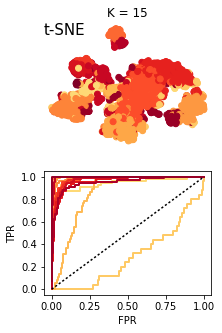

In [37]:
make_iteration(15, 0.02);

[31  6 10 18 30  3 25  2  6  6  9 20]


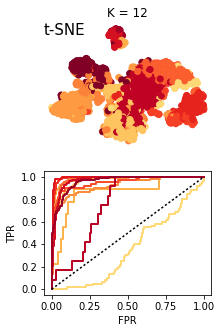

In [38]:
make_iteration(12, 0.02);

[4 4 3 5 5 3 3 0 4 3]


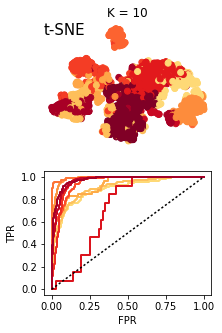

In [39]:
make_iteration(10, 0.01);

[ 3 27 17  4 30  6  5 22 15]


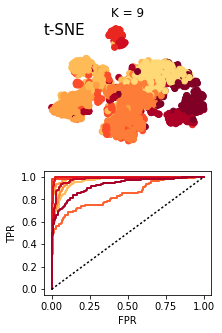

In [42]:
make_iteration(9, 0.02);

[93 24 22 70 45 21 16]


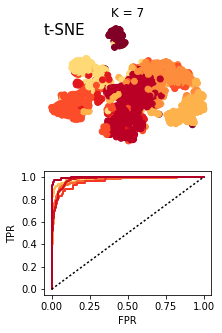

In [59]:
figsize(3, 5)
c, lr_res, lr = make_iteration(7, 0.03);

We stop at 7 clusters, which seem very easy predict. Again we can create the marker map.

In [60]:
top_markers = cell_types.get_top_markers(lr_res, 5)

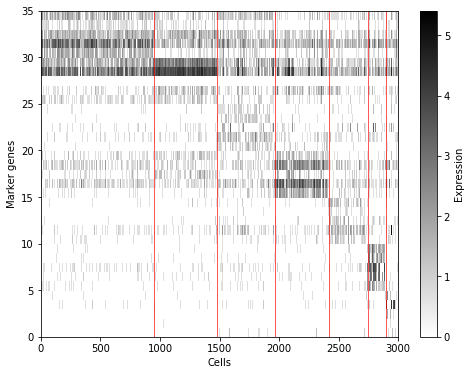

In [61]:
figsize(8, 6)
cell_types.plot_marker_map(s, c, top_markers)

Obviosuly this is a lot noisier than the simulated data. Another thing we notice is that the number of cells per cluster is much less even than for the simulated data. This will cause some issues with interpreting the ROC curves, but in practice we want to try to have some not too small minimal size for clusters in order to keep the actionable.

In order to quickly interpret the clusters, and read out what the predictive genes are, the `plot_marker_table` command will print predictive weights and names of top marker genes for each cluster.

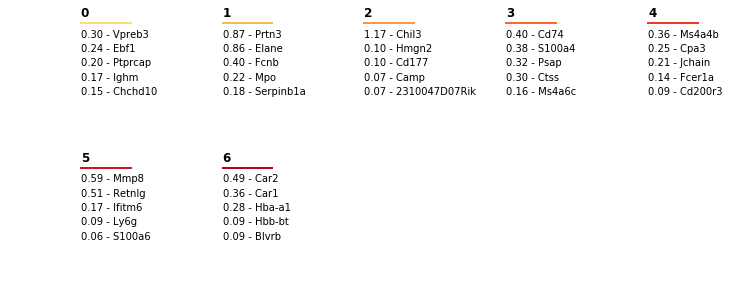

In [62]:
figsize(10, 20)
cell_types.plot_marker_table(top_markers, lr)

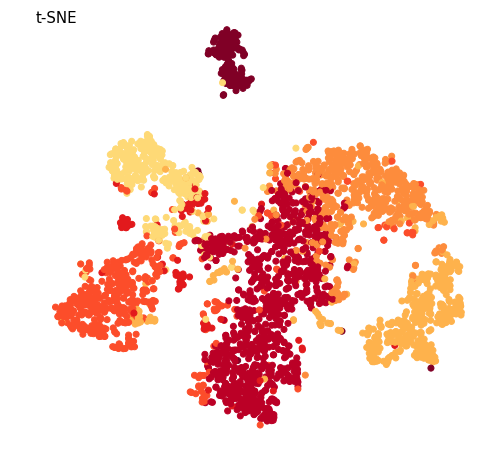

In [64]:
figsize(8, 8)
plot_clusters(c)

I find this workflow fairly straightforward and quick to work around. There are some clar drawbacks of course. It is quite manual, and we are not quantifying the uncertainty of these predictive weights.